# Generating Sequential Data

This is a quick example on how we could use algorithms like PrivBayes and MarginalSynthesizer to generate sequential data.

Our current repo is still very much work-in-progress, so you may run into some errors. Also, there will likely be some significant changes to the code structure in the future.

# Environment

## Library Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
from itertools import product

## Jupyter-specific Imports and Settings

In [2]:
# set printing options
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')
from importlib import reload

## Import local libraries

In [9]:
from synthesis.synthesizers.privbayes import PrivBayes, APPair
from synthesis.synthesizers.marginal import MarginalSynthesizer

# Load and Preprocess datasets

In [4]:
# load raw df where each record represents one event
df = ...

Flatten sequential data to ensure all information about one entity is present in a single record. Ideally as a sklearn.Transformer to ensure compatibility with other Transformers and sklearn.Pipeline. Implement an inverse transform function to revert back to the original representation.

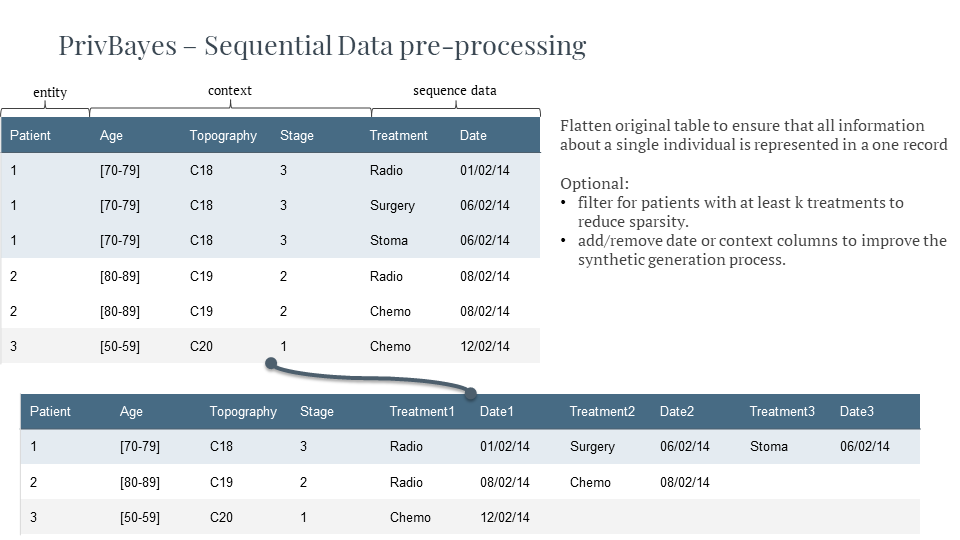

In [5]:
# develop transformer to flatten the table
FlattenTransformer = ...
# df = FlattenTransformer.fit_transform(df)

Here we load a example df that is already flattened.

Note we did not include identifiers, as these do not contain any statistical information we aim to preserve.

In [30]:
df = pd.DataFrame({
    'age': ['70-79', '80-89', '50-59'],
    'topography': ['C18', 'C19', 'C20'],
    'stage': [3, 2, 1],
    'treatment1': ['Radio', 'Radio', 'Chemo'],
    'date1': ['01/02/14', '08/02/14', '12/02/14'],
    'treatment2': ['Surgery', 'Chemo', np.nan],
    'date2': ['06/02/14', '08/02/14', np.nan],
    'treatment3': ['Stoma', np.nan, np.nan],
    'date3': ['06/02/14', np.nan, np.nan], 
})

# expand dataset size by copying records
increase_size = 100
df = pd.concat([df]*increase_size, ignore_index=True)
df.head()

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,70-79,C18,3,Radio,01/02/14,Surgery,06/02/14,Stoma,06/02/14
1,80-89,C19,2,Radio,08/02/14,Chemo,08/02/14,NaN,NaN
2,50-59,C20,1,Chemo,12/02/14,NaN,NaN,NaN,NaN
3,70-79,C18,3,Radio,01/02/14,Surgery,06/02/14,Stoma,06/02/14
4,80-89,C19,2,Radio,08/02/14,Chemo,08/02/14,NaN,NaN


Make sure to bin columns with high cardinality to speed up the generation process. Also check that columns don't contain unique values that are specific to individuals as these will be sampled and thus indicate that these individuals are present in the original data, e.g. dates, addresses, unique treatments. 

Note we developed some Transformers in the past. However these have not been thoroughly tested and documented yet. You can still try them. In case you run into any issues let me know or see if you can fix them yourself.

Currently we support the following:

In [31]:
# generalize continuous or high-cardinality categorical columns
from synthesis.transformers import GeneralizeContinuous, GeneralizeCategorical

# generalize date sequences, i.e. the first date column is used as reference and the subsequent date columns
# represent the days after the previous date. Make sure to specify the order of the date columns.
from synthesis.transformers.sequence import GeneralizeDateSequence

For an example on how to generalize categorical columns, see the Appendix at the bottom of this notebook. 

Here we show how to use GeneralizeDateSequence. 

In [32]:
date_sequence = ['date1', 'date2', 'date3']
gds = GeneralizeDateSequence(date_sequence=date_sequence)
df[date_sequence] = gds.fit_transform(df[date_sequence])

In [33]:
df.head(2)

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,70-79,C18,3,Radio,2014-01,Surgery,151.0,Stoma,0.0
1,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN


# Generate data

Set privacy budget epsilon. The lower you set epsilon the more noise is introduced. If you'd like to verify how the algorithm behaves without any noise set epsilon to float(np.inf)

In [34]:
epsilon = float(np.inf)
# epsilon = 1

## PrivBayes

We either let the PrivBayes algorithm learn the network or we define it ourself. Since we know the order of the treatment columns it makes sense for us to define the network. This can be done in the following manner. Just make sure that the network is a direct acyclic graph (DAG) and feel to experiment with different setups.

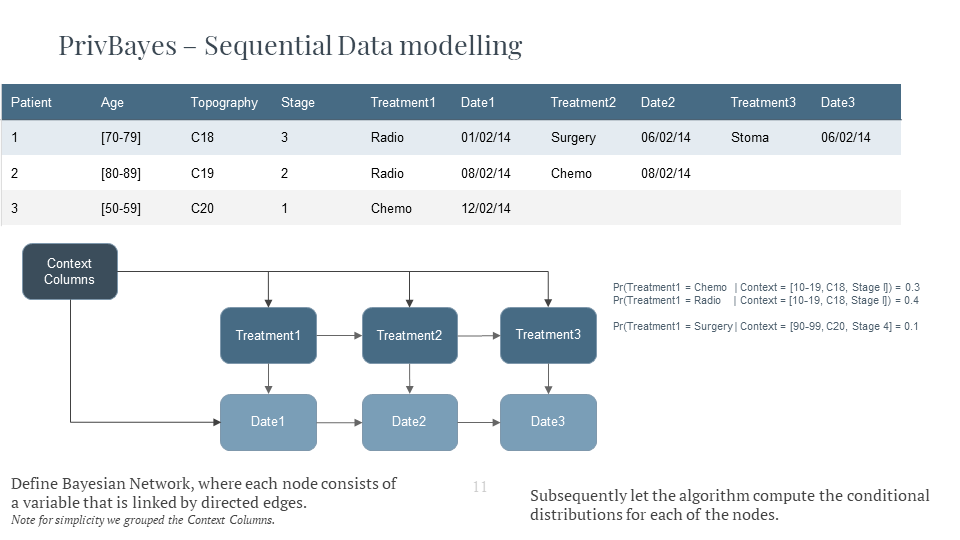

In [35]:
init_network = [
    APPair('age', None),
    APPair('topography', ['age']),
    APPair('stage', ['age', 'topography']),
    APPair('treatment1', ['topography', 'stage']),
    APPair('date1', ['age', 'treatment1']),
    APPair('treatment2', ['stage', 'treatment1']),
    APPair('date2', ['treatment1', 'date1']),
    APPair('treatment3', ['stage', 'treatment2']),
    APPair('date3', ['treatment2', 'date2']),
]

Since we initialize the network, we need to specify some of the hyperparameters ourselves as well. In a future version we hope to let PrivBayes discover these automatically. Letting the user define the network is an experimental feature that was not in the original PrivBayes paper.

In [36]:
epsilon_split = 0 # as we initalize the network, we dedicate the full epsilon budget to the computation of the CPTs
degree_network = 2 # maximum number of parents a node can have - in our example each node has max 2 parents.

In [37]:
pb = PrivBayes(epsilon=epsilon, epsilon_split=epsilon_split)
pb.set_network(init_network)
pb.fit(df)

# synthesize data
df_pb = pb.sample()

1/9 - init node age - with parents: None
2/9 - init node topography - with parents: ['age']
3/9 - init node stage - with parents: ['age', 'topography']
4/9 - init node treatment1 - with parents: ['topography', 'stage']
5/9 - init node date1 - with parents: ['age', 'treatment1']
6/9 - init node treatment2 - with parents: ['stage', 'treatment1']
7/9 - init node date2 - with parents: ['treatment1', 'date1']
8/9 - init node treatment3 - with parents: ['stage', 'treatment2']
9/9 - init node date3 - with parents: ['treatment2', 'date2']
Learned Network Structure

Learning conditional probabilities: age - with parents None ~ estimated size: 3
Learning conditional probabilities: topography - with parents ['age'] ~ estimated size: 9
Learning conditional probabilities: stage - with parents ['age', 'topography'] ~ estimated size: 27
Learning conditional probabilities: treatment1 - with parents ['topography', 'stage'] ~ estimated size: 18
Learning conditional probabilities: date1 - with parents ['

Number of records generated: 300 / 300
Synthetic Data Generated



In [38]:
df_pb.head()

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,50-59,C20,1,Chemo,2014-12,NaN,NaN,NaN,NaN
1,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN
2,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN
3,70-79,C18,3,Radio,2014-01,Surgery,151.0,Stoma,0.0
4,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN


## Marginal Synthesizer
Optional: repeat experiment with Marginal Synthesizer.

In [39]:
ms = MarginalSynthesizer(epsilon=epsilon)
ms.fit(df)
df_ms = ms.sample()

Marginal fitted: age
Marginal fitted: topography
Marginal fitted: stage
Marginal fitted: treatment1
Marginal fitted: date1
Marginal fitted: treatment2
Marginal fitted: date2
Marginal fitted: treatment3
Marginal fitted: date3


Column sampled: age
Column sampled: topography
Column sampled: stage
Column sampled: treatment1
Column sampled: date1
Column sampled: treatment2
Column sampled: date2
Column sampled: treatment3
Column sampled: date3


In [40]:
df_ms.head(3)

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,80-89,C18,1,Chemo,2014-08,Surgery,151.0,Stoma,0.0
1,50-59,C19,2,Radio,2014-01,NaN,NaN,NaN,0.0
2,80-89,C19,1,Radio,2014-12,Chemo,NaN,Stoma,NaN


# Evaluation

In [41]:
def check_treatment_sequence_consistency(df):
    treatment3_without_treatment2  = df[(df['treatment2'] == 'nan') & (df['treatment3'] != 'nan')]
    if not treatment3_without_treatment2.empty:
        print('{} records where treatment3 exists while treatment2 is missing:'.format(len(treatment3_without_treatment2)))
        return treatment3_without_treatment2
    print('No sequence errors detected\n')

print('PrivBayes')
check_treatment_sequence_consistency(df_pb)

# print('MarginalSynthesizer')
# check_treatment_sequence_consistency(df_ms)

PrivBayes
No sequence errors detected



# Postprocess
Inverse all the transformations on the generated synthetic data to revert back to the original representation.

In [42]:
df_pb.head()

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,50-59,C20,1,Chemo,2014-12,NaN,NaN,NaN,NaN
1,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN
2,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN
3,70-79,C18,3,Radio,2014-01,Surgery,151.0,Stoma,0.0
4,80-89,C19,2,Radio,2014-08,Chemo,0.0,NaN,NaN


Observe the inverse of GeneralizeDateSequence. 
1. A random day is sampled for the first date column - this will be our reference date. 
2. The other dates are computed in order by adding the number days to the prior date.

In [43]:
df_pb[date_sequence] = gds.inverse_transform(df_pb[date_sequence])
df_pb.head()

,age,topography,stage,treatment1,date1,treatment2,date2,treatment3,date3
0,50-59,C20,1,Chemo,2014-12-31,NaN,NaT,NaN,NaT
1,80-89,C19,2,Radio,2014-08-02,Chemo,2014-08-02,NaN,NaT
2,80-89,C19,2,Radio,2014-08-23,Chemo,2014-08-23,NaN,NaT
3,70-79,C18,3,Radio,2014-01-27,Surgery,2014-06-27,Stoma,2014-06-27
4,80-89,C19,2,Radio,2014-08-18,Chemo,2014-08-18,NaN,NaT


Make sure to also inverse all the other Transformers you've applied to the original dataset. 

In [44]:
# todo: still to be implemented
# df_pb = FlattenTransformer.inverse_transform(df_pb)
# df_pb = ...Transformer.inverse_transform(df_pb)

# Appendix

PrivBayes can run into issues when columns have high cardinality, as the conditional distributions will be very large (first make sure to test this though!). If this is the case, then we could reduce the cardinality by grouping (i.e. generalizing) column categories.

Ideally we do the grouping ourselves, but we can also let an algorithm make arbitrary groups. For an example see below.

In [46]:
from synthesis.transformers import GeneralizeCategorical

In [47]:
df_alphabet = pd.DataFrame({'letters': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
                                        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']}).reset_index()
df_alphabet.head(10)

,index,letters
0,0,A
1,1,B
2,2,C
3,3,D
4,4,E
5,5,F
6,6,G
7,7,H
8,8,I
9,9,J


Instantiate GeneralizeCategorical
- specify how many bins you want - more bins results retains more information but at the cost of large CPTS. 
- specify epsilon - used to compute the DP marginal distribution of each group (note if you use multiple DP algorithms, make sure to sum all the epsilons you used to generate to data to get the total epsilon value, i.e. theory of composition)

GeneralizeCategorical now creates groups according to the number of bins specified by the user. For each of these groups we store a differentially private marginal distribution. 

In [48]:
epsilon = float(np.inf)
gen_cat = GeneralizeCategorical(epsilon=epsilon, n_bins=10)

categorical_columns = ['index', 'letters']
df_alphabet[categorical_columns] = gen_cat.fit_transform(df_alphabet[categorical_columns])

In [49]:
df_alphabet.head(10)

,index,letters
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,1.0
4,1.0,1.0
5,2.0,2.0
6,2.0,2.0
7,2.0,2.0
8,3.0,3.0
9,3.0,3.0


If we perform an inverse transform the algorithm will use these DP marginals to sample from the original values. In our case all the letters occurs only once and thus each group will have a roughly uniform distribution.

Here we perform the inverse transformation. As you can see we lost some letters of the alphabet and some occur more than once.

In [50]:
df_alphabet_inv = gen_cat.inverse_transform(df_alphabet[categorical_columns])
df_alphabet_inv['letters'].value_counts().sort_index()

A    2
C    1
E    2
F    2
H    1
I    1
J    1
L    3
N    2
Q    1
R    2
S    1
T    1
V    2
W    1
X    1
Y    1
Z    1
Name: letters, dtype: int64

In conclusion, you always lose information when generalizing columns. Also, after generalization PrivBayes will only preserve the statistical patterns between these grouped values and other columns.